# Multi-label classification model

The model aims to classify the transcripts' sentences that belong to three different international courts.

The dataset that is considered for this project can be found at: TBD

The procedure followed to extract such sentences is described as follows:
- Relevant cases were chosen directly from the webpage of each international court
- Each transcript has a different format file (*.pdf, *.doc, or *.htm{( )|l}) and a cleaning process was applied in order to remove either uninformative or irrelevant information for the classification model
- Each cleaned transcript version was stored into a .txt file
- a
- b
- etc. 

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/"Colab Notebooks"
username = "IsaacOlguin"
repository =  "AutomatedTraumaDetectionInGCT"
%cd {repository}
%pwd
%ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/AutomatedTraumaDetectionInGCT
01_WebScraping_TribunalTranscriptCases.ipynb  input/      output/
02_Multilabel_Classification_Model.ipynb      LICENSE     __pycache__/
dev_analysis/                                 logs/       README.md
doc_resources/                                luima_sbd/  src/


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 30.3 MB/s 
     |████████████████████████████████| 182 kB 78.9 MB/s 
     |████████████████████████████████| 7.6 MB 64.0 MB/s 


In [4]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

import src.multi_label_classif_model_utilities as mlclassif_utilities

## Globals

In [5]:
PATH_DATASET = "input/dataset/Dataset.xlsx"
INDEX_COLUMNS_DATASET = 0
LIST_NAME_COLUMNS_DATASET = ["span", "role", "trauma", "court"]

GLB_RETURN_ATTENTION_MASK = True

# Globals for the model
EPOCHS = 3
EMBEDDING_SIZE = 512
NUM_CLASSES = 5
BATCH_SIZE = 16

## Dataset

In [6]:
df_dataset = mlclassif_utilities.import_dataset_from_excel(PATH_DATASET, INDEX_COLUMNS_DATASET, LIST_NAME_COLUMNS_DATASET)
df_dataset.head()

,span,role,trauma,court
0,P R O C E E D I N G S\n(Judges enter courtroom)\n,Court Proceedings,0,ECCC
1,MR. PRESIDENT:\nPlease be seated. The Court i...,Judge,0,ECCC
2,"MS. STUDZINSKY:\nMr. President, good morning. ...",Lawyer,0,ECCC
3,I would like to have the following information...,Lawyer,0,ECCC
4,"MR. WERNER:\nMr. President, just to inform you...",Lawyer,0,ECCC


In [7]:
classes_dataset = mlclassif_utilities.get_unique_values_from_dataset(df_dataset, "role")
print(f"Num of different roles in the dataset is {len(classes_dataset)} which are:")
for index, elem in enumerate(classes_dataset):
    print("\t", index+1, "-", elem)
    
courts_dataset = mlclassif_utilities.get_unique_values_from_dataset(df_dataset, "court")
print(f"Num of different courts in the dataset is {len(courts_dataset)} which are:")
for index, elem in enumerate(courts_dataset):
    print("\t", index+1, "-", elem)

Num of different roles in the dataset is 5 which are:
	 1 - Court Proceedings
	 2 - Judge
	 3 - Lawyer
	 4 - Witness
	 5 - Accused
Num of different courts in the dataset is 2 which are:
	 1 - ECCC
	 2 - ICTY


### Distribution of all classes within the dataset

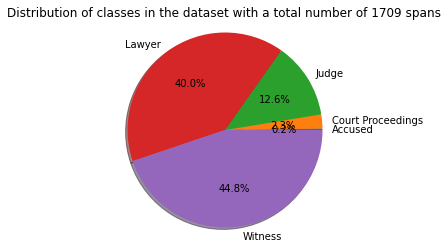

,role,span
0,Accused,4
1,Court Proceedings,40
2,Judge,216
3,Lawyer,683
4,Witness,766


In [8]:
distribution_classes = mlclassif_utilities.get_distribution_classes_from_dataset(df_dataset, ["role"], "span")

labels = list(distribution_classes["role"])
sizes = list(distribution_classes["span"])

fig1, ax1 = plt.subplots()
ax1.set_title(f'Distribution of classes in the dataset with a total number of {distribution_classes["span"].sum()} spans')
ax1.pie(sizes, labels=labels, autopct='%2.1f%%', shadow=True, startangle=0) #'%1.1f%%'
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

distribution_classes

## Setup

### Device

Get the GPU device if exists, otherwise get the cpu as default dev.

In [9]:
device = mlclassif_utilities.get_gpu_device_if_exists()

print(f"\n\n==> Selected device is '{device}' <==")

There are 1 GPU(s) available.

These are the available devices:
	 1 - Tesla T4


==> Selected device is 'cuda' <==


## Model

### Tokenizer

In [10]:
#If no parameters are sent, default values are considered. 
#    IDModel:      Bert
#    Model namel:  bert-base-uncased
#    Do uncase:    True

tokenizer = mlclassif_utilities.get_tokenizer() 

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Bert tokenizer was loaded successfully (bert-base-uncased) 
	 do_lower_case=True


### Get list of all sentences and all classes

In [11]:
list_all_spans = list(df_dataset["span"])
list_all_classes = list(df_dataset["role"])

### Max length of a sentence among all sentences within the dataset

In [12]:
mlclassif_utilities.get_max_length_of_a_sentence_among_all_sentences(tokenizer, list_all_spans, False)

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  550 found at index 37 . Sentence is:


 Then they started to interrogate me and beat me up.  It was --
the interrogation location was in a house outside the compound.
It was behind the Building A.  They cut me and they asked me to
lie down on the floor with my face facing down and they had a
bunch of sticks and they dropped it on the floor and it made
noise.  And I was asked to choose which stick I preferred.  And I
responded, "Whichever stick I choose, it is still a stick that
you will use to beat me up so it is up to you, Brother, to decide
which one you want to use."
Mam Nai stood up and grabbed a stick and started to beat me up.
After he felt exhausted, then another person came to take turn to
beat me up.  So that Mam Nai was Mam Nai alias Chan.  He got his
skin condition with a spotty skins and quite a red in his face.
He asked me to count the lashes and when I counted up to 10
lashes, he said, "How come you count to 10 lashes?  I only beat
you for one lash."

550

### Tokenize sentences

In [13]:
# If _return_attention_mask, a tuple of two lists is given (tensor_of_inputs, tensor_of_attention_masks)
all_spans_tokenized = mlclassif_utilities.get_all_spans_tokenized(
    mlclassif_utilities.GLB_BERT_MODEL_ID, 
    tokenizer,
    list_all_spans,
    _add_special_tokens = True, 
    _max_length = 512,
    _pad_to_max_length = True,
    _return_attention_mask = GLB_RETURN_ATTENTION_MASK, 
    type_tensors = mlclassif_utilities.GLB_PYTORCH_TENSOR_TYPE
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
input_ids = None
attention_masks = None

if GLB_RETURN_ATTENTION_MASK:
    input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[0])
    attention_masks = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[1])
else:
    input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized)

### Split dataset

In [15]:
numeric_classes = mlclassif_utilities.convert_list_span_classes_into_numeric_values(classes_dataset, list_all_classes)
numeric_classes = mlclassif_utilities.convert_list_labels_into_pytorch_tensor(numeric_classes)

In [16]:
### Split dataset
train_labels_corpus, train_input_ids, train_attention_masks, val_labels_corpus, val_input_ids, val_attention_masks, test_labels_corpus, test_input_ids, test_attention_masks = mlclassif_utilities.split_dataset_train_val_test(numeric_classes, input_ids, attention_masks)

CORPUS TRAINING AND VALIDATION:  
	 Length labels 1623 
	 Length input_ids 1623 
	 Length attention_masks 1623 

	CORPUS TRAINING:  
		 Length labels 1460 
		 Length input_ids 1460 
		 Length attention_masks 1460
	CORPUS VALIDATION:  
		 Length labels 163 
		 Length input_ids 163 
		 Length attention_masks 163

CORPUS TEST:  
	 Length labels 86 
	 Length input_ids 86 
	 Length attention_masks 86 



In [17]:
### Pending k-Fold

### Create datasets and dataloaders

In [18]:
train_dataset = mlclassif_utilities.create_tensor_dataset(train_input_ids, train_attention_masks, train_labels_corpus)
val_dataset = mlclassif_utilities.create_tensor_dataset(val_input_ids, val_attention_masks, val_labels_corpus)
test_dataset = mlclassif_utilities.create_tensor_dataset(test_input_ids, test_attention_masks, test_labels_corpus)

train_dataloader = mlclassif_utilities.create_dataloader(train_dataset, BATCH_SIZE)
val_dataloader = mlclassif_utilities.create_dataloader(val_dataset, BATCH_SIZE)
test_dataloader = mlclassif_utilities.create_dataloader(test_dataset, BATCH_SIZE)

### Create model

In [19]:
model = mlclassif_utilities.create_model(
    mlclassif_utilities.GLB_BERT_MODEL_ID,
    mlclassif_utilities.GLB_BERT_BASE_UNCASED_MODEL_NAME,
    NUM_CLASSES,
    True #RunInGPU
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Get optimizer and scheduler

In [20]:
optimizer = mlclassif_utilities.get_optimizer(model)
scheduler = mlclassif_utilities.get_scheduler(optimizer)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Train and validate the model

In [21]:
model2 = mlclassif_utilities.train_and_validate(model, device, EPOCHS, optimizer, scheduler, train_dataloader, val_dataloader)


======== Epoch 1 / 3 ========
Training...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is 

Epoch 1 : 
            Train_acc : 0.6822947364351378
            Train_F1 : 0.35368571347617006
            Train_precision : 0.3857244799776066
            Train_recall : 0.3527834754059498

  Average training loss: 0.60
  Training epoch took: 0:02:14

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Epoch 1 : 
                Valid_acc : 0.9349754114324665
                Valid_F1 : 0.7143268259723347
                Valid_precision : 0.696245529193776
                Valid_recall : 0.7391441657281578
  Accuracy: 0.90
  Validation Loss: 0.28
  Validation took: 0:00:06

======== Epoch 2 / 3 ========
Training...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Epoch 2 : 
            Train_acc : 0.9436025825148929
            Train_F1 : 0.6289879617928
            Train_precision : 0.6916007166744518
            Train_recall : 0.6179157137189433

  Average training loss: 0.16
  Training epoch took: 0:02:13

Running Validation...
Epoch 2 : 
                Valid_acc : 0.9504181688710065
                Valid_F1 : 0.9068882044034322
                Valid_precision : 0.8870469596172601
                Valid_recall : 0.953825255141814
  Accuracy: 0.96
  Validation Loss: 0.19
  Validation took: 0:00:06

======== Epoch 3 / 3 ========
Training...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Epoch 3 : 
            Train_acc : 0.9805007099998698
            Train_F1 : 0.9168455287768309
            Train_precision : 0.9308206920054299
            Train_recall : 0.905881181002644

  Average training loss: 0.08
  Training epoch took: 0:02:12

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3 : 
                Valid_acc : 0.9416646471286042
                Valid_F1 : 0.8327803516533439
                Valid_precision : 0.8298372909030142
                Valid_recall : 0.8701391258489299
  Accuracy: 0.95
  Validation Loss: 0.21
  Validation took: 0:00:06

Training complete!
Total training took 0:06:56 (h:mm:ss)
